# 3. Linear Models for Regression

In [1]:
import sys
sys.path.append("../")
from importlib import reload
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from prmlmy.util import c_, norm2s, calc_range
from numpy import asarray
from numpy.linalg import inv, pinv

seed = 1234

In [8]:
from scipy.stats import multivariate_normal
from prmlmy.preprocess import GaussianFeature, PolynomialFeature, SigmoidalFeature
from prmlmy.linear import (
    BayesianRegression,
    EmpiricalBayesRegression,
    LinearRegression,
    RidgeRegression
)
from prmlmy.pipe import SimplePipe

In [3]:
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

def cubic(x):
    return x * (x - 5) * (x + 5)

In [4]:
def create_toy_data(func, sample_size, std, domain=[0, 1], seed=seed):
    np.random.seed(seed)
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

In [5]:
def plot_regression(model, x_train, y_train, ci=False, y_func=None, y_func_name=None, 
                    x_range=None, y_range=None, pad_ratio=0.2, points=100, title=None, ax=None):
    """
    x_train: must 1-d array
    """
    if ax is None:
        ax = plt
        
    if x_range:
        x_min, x_max = x_range
    else:
        x_min, x_max = calc_range(x_train, pad_ratio)
    x_test = np.linspace(x_min, x_max, points)
    
    ax.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    if y_func:
        y_test = y_func(x_test)
        ax.plot(x_test, y_test, label=y_func_name)
    
    res = model.predict(x_test, return_std=ci)
    if ci:
        y, y_std = res
        ax.fill_between(x_test, y - y_std, y + y_std, alpha=0.5, label="std.", color='orange')
    else:
        y = res
    ax.plot(x_test, y, label="prediction")
    
    ax.set_title(title)
    if y_range:
        ax.set_ylim(*y_range)
        
    ax.legend()

## 3.1 Linear Basis Function Models

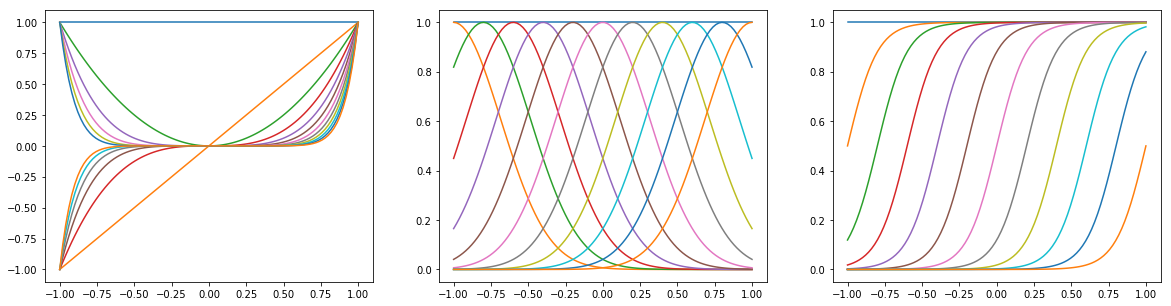

In [6]:
X_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x = np.linspace(-1, 1, 100)
X_polynomial = PolynomialFeature(11).transform(x)
X_gaussian = GaussianFeature(np.linspace(-1, 1, 11), 0.1).transform(x)
X_sigmoidal = SigmoidalFeature(np.linspace(-1, 1, 11), 10).transform(x)

plt.figure(figsize=(20, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
    plt.subplot(1, 3, i + 1)
    for j in range(12):
        plt.plot(x, X[:, j])

## least squares

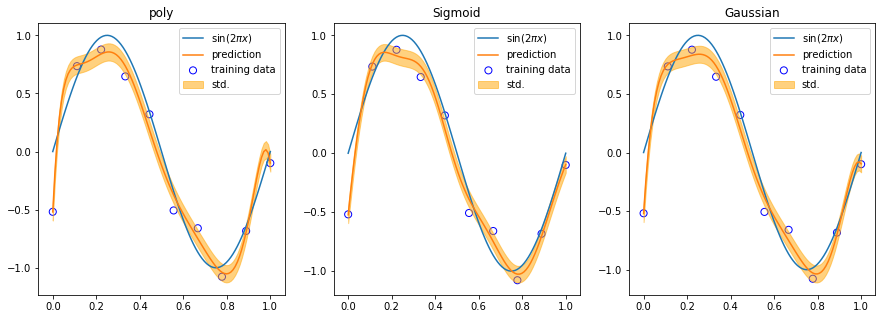

In [9]:
X_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
features = [
    ("poly", PolynomialFeature(8)), 
    ("Sigmoid", SigmoidalFeature(np.linspace(0, 1, 8), 10)), 
    ("Gaussian", GaussianFeature(np.linspace(0, 1, 8), 0.1)), 
]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for (name, feature), ax in zip(features, axs.flatten()):
    model = SimplePipe([
        feature, 
        LinearRegression(), 
    ])
    model.fit(X_train, y_train)
    plot_regression(model, X_train, y_train, y_func=sinusoidal, y_func_name="$\sin(2\pi x)$", 
                    ci=True, pad_ratio=0, title=name, ax=ax)

### 3.1.4 Regularized least squares

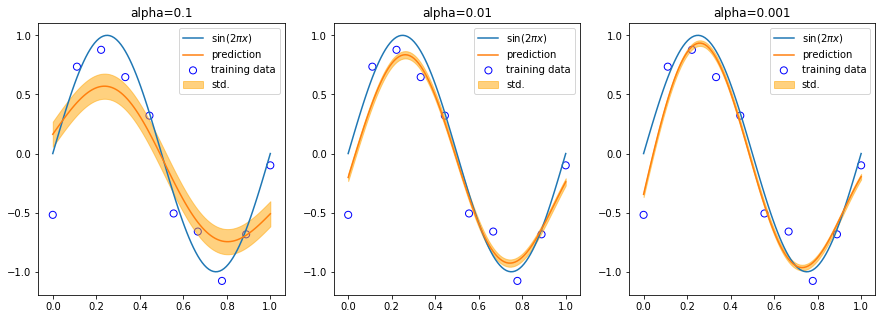

In [10]:
X_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for alpha, ax in zip([0.1, 0.01, 0.001], axs.flatten()):
    model = SimplePipe([
        GaussianFeature(np.linspace(0, 1, 8), 0.1), 
        RidgeRegression(alpha=alpha), 
    ])
    model.fit(X_train, y_train)
    plot_regression(model, X_train, y_train, y_func=sinusoidal, y_func_name="$\sin(2\pi x)$", 
                    ci=True, pad_ratio=0, title=f"alpha={alpha}", ax=ax)

## 3.2 The Bias-Variance Decomposition

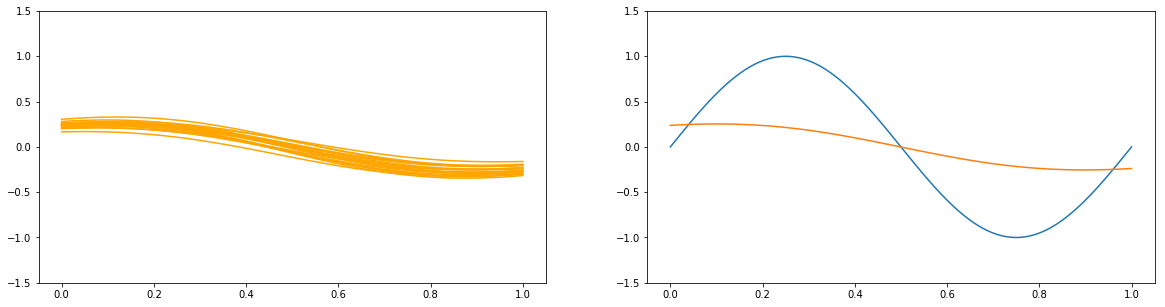

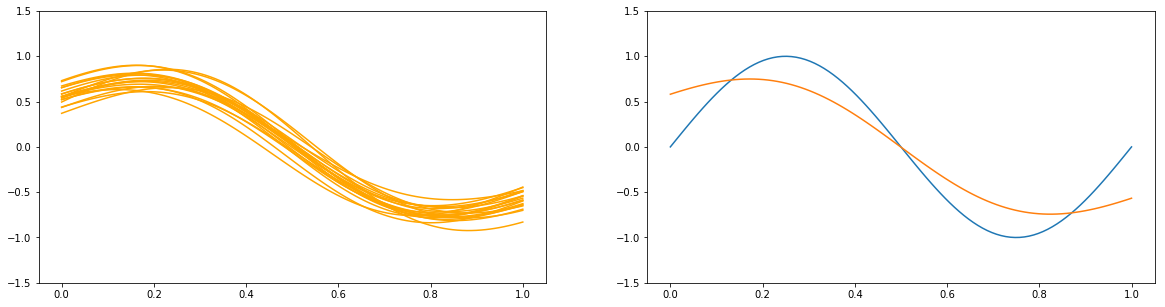

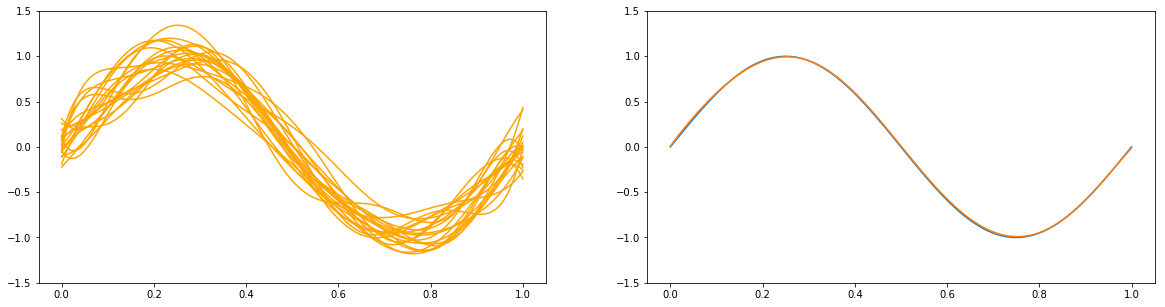

In [13]:
# feature = PolynomialFeature(24)
feature = GaussianFeature(np.linspace(0, 1, 24), 0.1)
# feature = SigmoidalFeature(np.linspace(0, 1, 24), 10)

for a in [1e2, 1., 1e-9]:
    y_list = []
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    for i in range(100):
        x_train, y_train = create_toy_data(sinusoidal, 25, 0.25, seed=None)
        X_train = feature.transform(x_train)
        x_test = np.linspace(0, 1, 100)
        X_test = feature.transform(x_test)
        model = BayesianRegression(alpha=a, beta=1.)
        model.fit(X_train, y_train)
        y = model.predict(X_test)
        y_list.append(y)
        if i < 20:
            plt.plot(x_test, y, c="orange")
    plt.ylim(-1.5, 1.5)
    
    plt.subplot(1, 2, 2)
    y_test = sinusoidal(x_test)
    plt.plot(x_test, y_test)
    plt.plot(x_test, np.asarray(y_list).mean(axis=0))
    plt.ylim(-1.5, 1.5)
    plt.show()

## 3.3 Bayesian Linear Regression

### 3.3.1 Parameter distribution

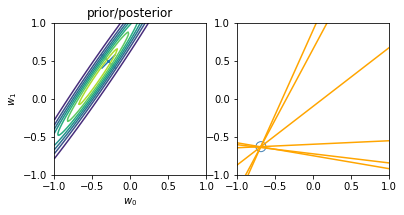

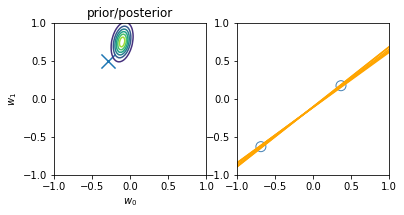

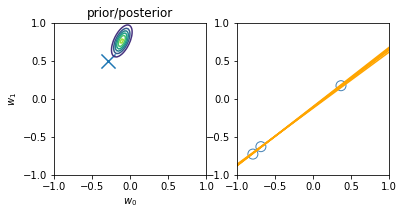

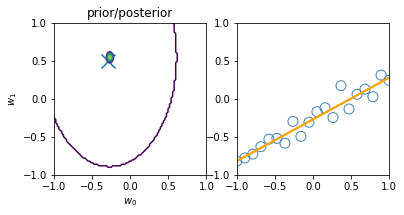

In [14]:
def linear(x):
    return -0.3 + 0.5 * x


x_train, y_train = create_toy_data(linear, 20, 0.1, [-1, 1])
x = np.linspace(-1, 1, 100)
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X = feature.transform(x)
model = BayesianRegression(alpha=1., beta=100.)

for begin, end in [[0, 1], [1, 2], [2, 3], [3, 20]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    plt.subplot(1, 2, 1)
    plt.scatter(-0.3, 0.5, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean=model.w_mean(), cov=model.w_cov()))
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
    plt.title("prior/posterior")

    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=1)
    plt.plot(x, model.predict(X, sample_size=6), c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### 3.3.2 Predictive distribution

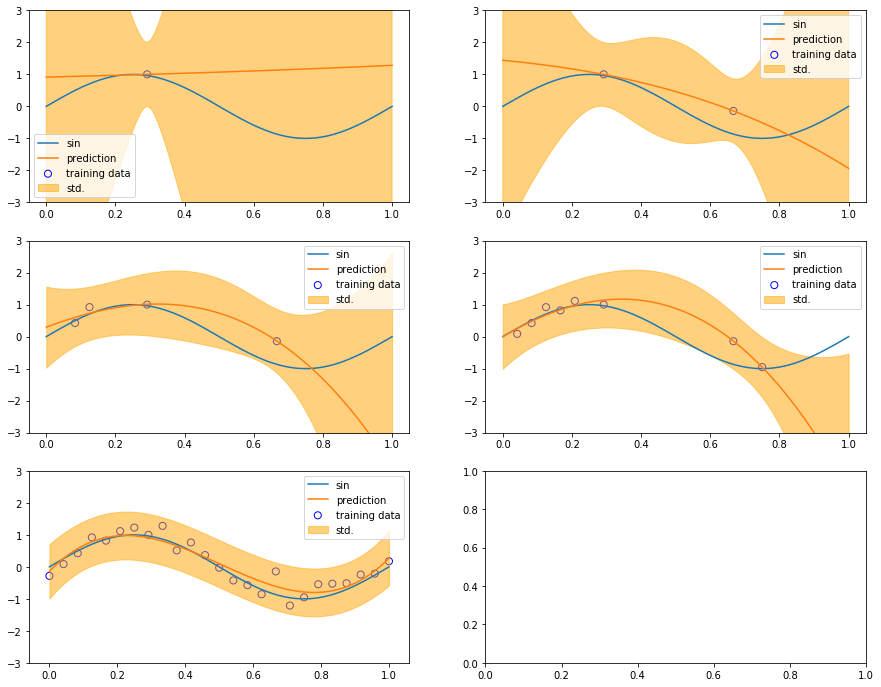

In [15]:
X_train, y_train = create_toy_data(sinusoidal, 25, 0.25)
model = SimplePipe([
    PolynomialFeature(degree=3), 
    BayesianRegression(alpha=1e-3, beta=2.), 
])
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
for ((begin, end), ax) in zip([[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]], axs.flatten()):
    model.fit(X_train[begin:end], y_train[begin:end])
    plot_regression(model, X_train[:end], y_train[:end], y_func=sinusoidal, y_func_name="sin", ci=True, 
                    x_range=(0, 1), y_range=(-3, 3), ax=ax)

# Kernel

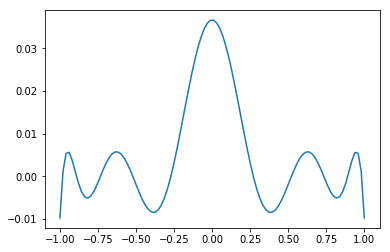

In [16]:
class EQKernel:
    def __init__(self, x, feature, alpha=0.1, beta=0.1):
        self.alpha = alpha
        self.beta = beta
        self.feature = feature
        A = feature.transform(x)
        self.S_N = pinv(beta * A.T @ A)
        
    def __call__(self, x1, x2):
        a1 = feature.transform(x1).T
        a2 = feature.transform(x2).T
        return (self.beta * a1.T @ self.S_N @ a2)[0][0]

x = np.linspace(-1, 1, 200)
feature = GaussianFeature(np.linspace(-1, 1, 100), 0.1)
feature = PolynomialFeature(10)
kernel = EQKernel(x, feature)

grid = np.linspace(-1, 1, 100)
y = asarray([kernel([0], [x]) for x in grid])
# y = asarray([kernel(asarray([0]), asarray([x])) for x in grid])

plt.plot(grid, y)

## 3.5 The Evidence Approximation

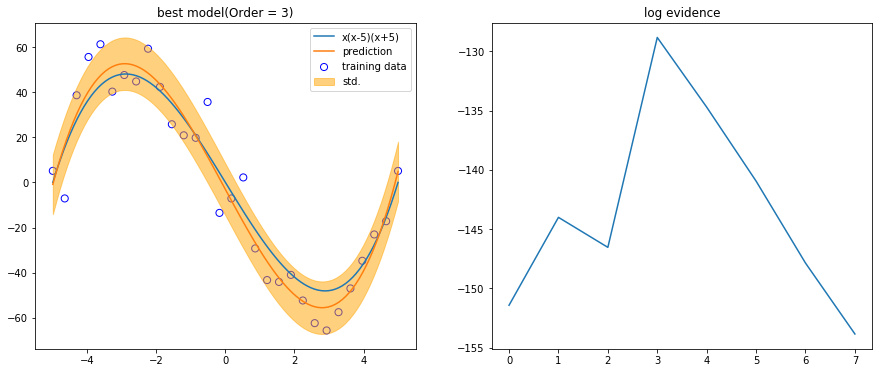

In [17]:
X_train, y_train = create_toy_data(cubic, 30, 10, [-5, 5])

models = []
for d in range(8):
    model = SimplePipe([
        PolynomialFeature(degree=d), 
        EmpiricalBayesRegression(alpha=100., beta=100., max_iter=100), 
    ])
    model.fit(X_train, y_train)
    models.append(model)
model = max(models, key=lambda m: m.score())

fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
plot_regression(model, X_train, y_train, y_func=cubic, pad_ratio=0, ci=True, 
                y_func_name="x(x-5)(x+5)", title=f"best model(Order = {model.estimator.M-1})", ax=axs[0])

degrees = [m.estimator.M - 1 for m in models]
evidences = [m.score() for m in models]
axs[1].plot(degrees, evidences)
axs[1].set_title("log evidence")
plt.show()